In [13]:
# Accedo a Google Drive
from google.colab import drive
drive.mount(r'/content/drive')

# Importo librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Accedo a la PWT. En este caso, yo la tengo cargada en mi drive :)
file_path_1 = '/content/drive/MyDrive/Colab Notebooks/economic-growth/pwt1001.xlsx' # Modificar el path según sea necesario
pwt = pd.read_excel(file_path_1, sheet_name="Data") # Poner el nombre de la hoja tal cual. Con esto armamos un dataframe

# Agrego como columnas las variables a calcular
pwt['S']=pwt['rdana']-pwt['rconna'] # Ahorro
pwt['Y per cápita']=pwt['rgdpna']/pwt['pop'] # PBI per cápita
pwt['Tasa de ahorro']=pwt['S']/pwt['rgdpna'] # Tasa de ahorro
pwt['Share de capital'] = 1 - pwt['labsh'] # Share de Capital
pwt['K per cápita']= pwt['rnna']/pwt['pop'] # Capital per cápita

# Tasas de crecimiento (calculadas como variaciones porcentuales, revisar)
pwt['n']= pwt['pop'].pct_change() * 100 # Tasa de crecimiento poblacional
pwt['Tasa de crecimiento de yt'] = pwt['Y per cápita'].pct_change() * 100 # Tasa de crecimiento del pbi per cápita
pwt['Tasa de crecimiento de kt'] = pwt['K per cápita'].pct_change() * 100 # Tasa de crecimiento del capital per cápita

# Residuo de Solow
pwt['PTF']= ((pwt['Tasa de crecimiento de yt']) - (pwt['n'] * pwt['labsh'])) - ((pwt['Tasa de crecimiento de kt'] * pwt['Share de capital']))

pwt["ln_yN"] = np.log(pwt["rgdpna"]/pwt["pop"])
pwt["ln_kN"] = np.log(pwt["rnna"]/pwt["pop"])
pwt["ln_hc"] = np.log(pwt["hc"])

# print(pwt) # Descomentar (sin dejar espacios!) para ver cómo quedó la pwt con los agregados

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-3978531162.py:22: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pwt['n']= pwt['pop'].pct_change() * 100 # Tasa de crecimiento poblacional
/tmp/ipython-input-3978531162.py:23: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  pwt['Tasa de crecimiento de yt'] = pwt['Y per cápita'].pct_change() * 100 # Tasa de crecimiento del pbi per cápita
/tmp/ipython-input-3978531162.py:24: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_met

In [14]:
# Preparación para análisis de convergencia
# Para esto necesitamos preparar un nuevo dataframe apto modelos, limpio
# Limpiamos la PWT para no tener datos faltantes :)
valores_faltantes_columna = pwt.isnull().sum()
columnas_a_descartar = valores_faltantes_columna[valores_faltantes_columna > 52000].index.tolist()
pwt_intermedia = pwt.drop(columns=columnas_a_descartar)
pwt_clean = pwt_intermedia #.dropna()
# Con esto obtenemos el df apto modelos ;)

# Selecciono los países con los que vamos a trabajar
paises = ["Greece", "Germany"]
subset = pwt_clean[pwt_clean["country"].isin(paises)].copy()


In [15]:
# Preparo el proxy con el que vamos a trabajar
file_path_2 = '/content/drive/MyDrive/Colab Notebooks/economic-growth/pat_ep_cp__final_bastaxfavor.xlsx' # Modificar el path según sea necesario
proxy = pd.read_excel(file_path_2, sheet_name= 'Sheet 1', header=None) # Con esto armamos un dataframe
years = proxy.iloc[9, 1:].tolist() # Extraigo los años
countries = proxy.iloc[10:, 0].tolist() # Extraemos los países
data = proxy.iloc[10:, 1:].reset_index(drop=True) # Extraemos los datos numéricos desde la fila 11 en adelante, columnas B en adelante

# Asignamos los nombres de columna: "country" + años
data.columns = years
data.insert(0, 'country', countries)

# Convertimos el DataFrame a formato largo
data_long = data.melt(id_vars='country', var_name='year', value_name='patentes')

# Aseguramos que el año sea tipo numérico (por si viene como string)
data_long['year'] = pd.to_numeric(data_long['year'], errors='coerce')

# Quiero trabajar con valores per cápita para garantizar la comparación
bd_merged = pd.merge(pwt_clean, data_long, on=["country", "year"], how="left")

# Aseguramos que la columna exista
bd_merged['patentes_pc'] = pd.to_numeric(bd_merged['patentes'], errors='coerce') / (bd_merged['pop']/1e6)

# Filtramos los países
subset = bd_merged[bd_merged['country'].isin(paises)]
subset = subset[subset["year"] >= 1970]

# print(subset.columns)

/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [16]:
# aseguramos numericidad y escala por millón
subset['patentes_pc'] = pd.to_numeric(subset.get('patentes_pc', subset.get('patentes', np.nan)), errors='coerce')

# patentes por millón
# subset['patentes_pc'] = subset['patentes'] / (subset['pop'] / 1e6)

# log(1+x) para evitar -inf por ceros
subset['ln_patpc'] = np.log1p(subset['patentes_pc'].fillna(0))

# Aplicamos un lag para mitigar simultaneidad
subset['ln_patpc_lag1'] = subset.groupby('country')['ln_patpc'].shift(1)



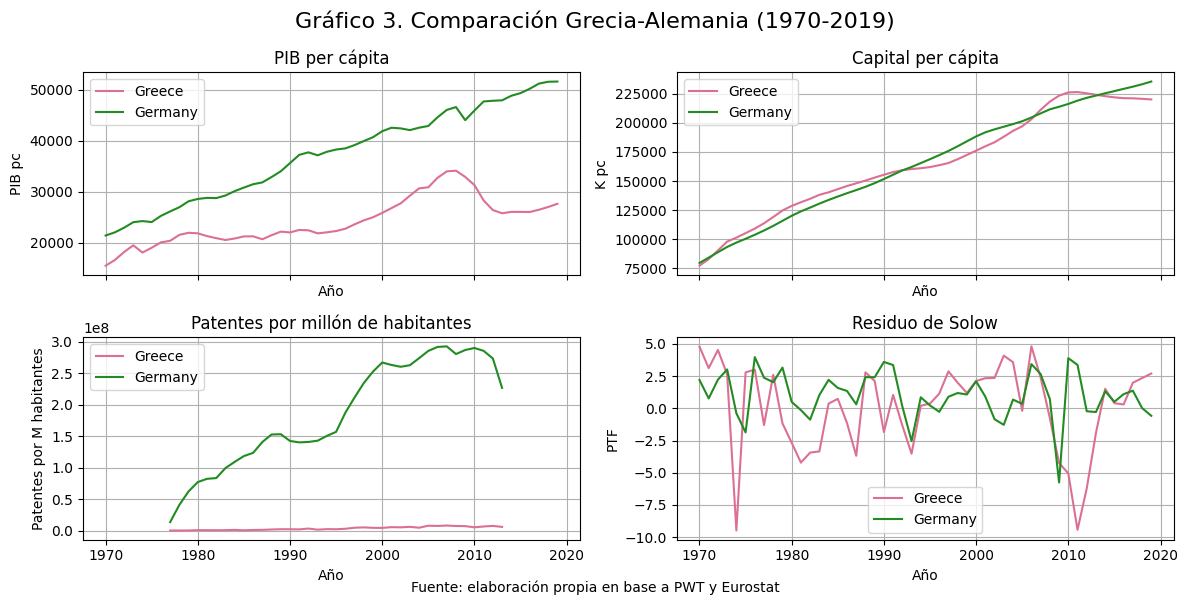

In [17]:
# Gráfico Grecia - Alemania
import matplotlib.pyplot as plt

# Diccionario de colores personalizados
colores = {
    'Greece': 'palevioletred',
    'Germany': 'forestgreen'
}

paises = {
    'Greece': 'Grecia',
    'Germany': 'Alemania'
}

fig, axes = plt.subplots(2, 2, figsize=(12,6), sharex=True)
fig.suptitle('Gráfico 3. Comparación Grecia-Alemania (1970-2019)', fontsize=16)


# PIB per cápita
for pais in paises:
    data = subset[subset["country"] == pais]
    color = colores.get(pais, None)
    axes[0, 0].plot(data["year"], data["Y per cápita"], label=pais, color=color)
axes[0, 0].set_title("PIB per cápita")
axes[0, 0].set_xlabel("Año")
axes[0, 0].set_ylabel("PIB pc")
axes[0, 0].grid(True)
axes[0, 0].legend()

# Capital per cápita
for pais in paises:
    data = subset[subset["country"] == pais]
    color = colores.get(pais, None)
    axes[0, 1].plot(data["year"], data["K per cápita"], label=pais, color=color)
axes[0, 1].set_title("Capital per cápita")
axes[0, 1].set_xlabel("Año")
axes[0, 1].set_ylabel("K pc")
axes[0, 1].grid(True)
axes[0, 1].legend()


# Patentes per cápita
for pais in paises:
    data = subset[subset["country"] == pais]
    color = colores.get(pais, None)
    axes[1, 0].plot(data["year"], data["patentes_pc"], label=pais, color=color)
axes[1, 0].set_title("Patentes por millón de habitantes")
axes[1, 0].set_xlabel("Año")
axes[1, 0].set_ylabel("Patentes por M habitantes")
axes[1, 0].grid(True)
axes[1, 0].legend()


# Residuo de Solow
for pais in paises:
    data = subset[subset["country"] == pais]
    color = colores.get(pais, None)
    axes[1, 1].plot(data["year"], data["PTF"], label=pais, color=color)
axes[1, 1].set_title("Residuo de Solow")
axes[1, 1].set_xlabel("Año")
axes[1, 1].set_ylabel("PTF")
axes[1, 1].grid(True)
axes[1, 1].legend()

fig.text(0.5, 0.01, 'Fuente: elaboración propia en base a PWT y Eurostat',
         ha='center', fontsize=10)

# Ajustar el espacio entre subplots
plt.tight_layout()


# Mostrar el gráfico
plt.show()